In [128]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [129]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [130]:
!wget $data -O course_lead_scoring.csv


--2025-10-21 00:39:07--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.02s   

2025-10-21 00:39:07 (3.73 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [131]:
df = pd.read_csv('course_lead_scoring.csv')

In [132]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [133]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = ['annual_income', 'interaction_count', 'lead_score', 'number_of_courses_viewed']

categorical, numerical

(['lead_source', 'industry', 'employment_status', 'location'],
 ['annual_income',
  'interaction_count',
  'lead_score',
  'number_of_courses_viewed'])

In [134]:
for col in df.columns:
    if col == 'converted':
        continue
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [137]:
y_train = df_train.converted.values
y_test = df_test.converted.values
y_val = df_val.converted.values

In [138]:
del df_train['converted']
del df_test['converted']
del df_val['converted']

In [139]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [140]:
# Q1
from sklearn.metrics import roc_auc_score

for col in numerical:
    # print(df_train[col].head())
    min_val = df_train[col].min()
    max_val = df_train[col].max()
    mid_point = (min_val + max_val) / 2
    y_score = (df_train[col].values >= mid_point)
    print(col, mid_point)
    print('midpoint', col, roc_auc_score(y_score, y_train))
    median = df_train[col].median()
    y_score = (df_train[col].values >= median)
    print(col, median)
    print('median', col, roc_auc_score(y_score, y_train))

annual_income 51427.5
midpoint annual_income 0.5446187873910279
annual_income 58010.5
median annual_income 0.545662100456621
interaction_count 4.0
midpoint interaction_count 0.6674829892911487
interaction_count 3.0
median interaction_count 0.6787216689560439
lead_score 0.5
midpoint lead_score 0.5864492923606224
lead_score 0.49
median lead_score 0.5891438106163313
number_of_courses_viewed 4.5
midpoint number_of_courses_viewed 0.694485294117647
number_of_courses_viewed 2.0
median number_of_courses_viewed 0.6853317053317053


In [141]:
# Q2
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [142]:
def predict(df_val, dv, model):
    dicts = df_val[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [143]:
dv, model = train(df_train, y_train)

In [144]:
y_pred = predict(df_val, dv, model)

In [145]:
round(roc_auc_score(y_val, y_pred), 4)

0.8171

In [122]:
# Q3

thresholds = np.arange(0.0, 1.0, 0.01)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn))

In [123]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,171,122,0,0
10,0.1,171,122,0,0
20,0.2,171,122,0,0
30,0.3,171,119,0,3
40,0.4,171,105,0,17
50,0.5,164,81,7,41
60,0.6,150,53,21,69
70,0.7,106,25,65,97
80,0.8,64,6,107,116
90,0.9,24,1,147,121


In [124]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

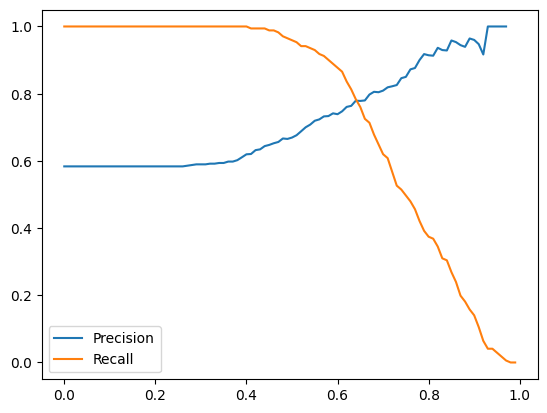

In [126]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [127]:
# Q4

df_scores['f1_score'] = 2 * ((df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall']))

df_scores.iloc[df_scores.f1_score.idxmax()]

threshold      0.570000
tp           156.000000
fp            57.000000
fn            15.000000
tn            65.000000
precision      0.732394
recall         0.912281
f1_score       0.812500
Name: 57, dtype: float64

In [102]:
# Q5

from sklearn.model_selection import KFold

n_splits = 5

# for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
for C in [1.0]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1.0 0.822 +- 0.036


In [103]:
# Q6

n_splits = 5

# for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
